# FBN1

FBN1 encodes the fibrillin-1 protein. Pathogenic variants in FBN1 are found in Marfan syndrome and a number of other disorders including  [Weill-Marchesani syndrome](https://omim.org/entry/608328) (WMS), [geleophysic dysplasia](https://omim.org/entry/231050) (GPHYSD), [acromicric dysplasia](https://omim.org/entry/102370) (ACMICD), and [Marfan lipodystrophy syndrome](https://omim.org/entry/616914).

We will investigate correlations between variant location and disease diagnosis.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1


# FBN1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FBN1.

In [2]:
gene_symbol = 'FBN1'
mane_tx_id = 'NM_000138.5'
mane_protein_id = "NP_000129.3"

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.23'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 144/144 [02:20<00:00,  1.02individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
79,Ectopia lentis
63,Myopia
52,Arachnodactyly
36,Aortic root aneurysm
32,Short foot
32,Short palm
29,Joint hypermobility
29,High palate
26,Scoliosis
23,Mitral valve prolapse


In [5]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
7,15_48508660_48508660_A_G,c.1759T>C (p.Cys587Arg),15,missense
7,15_48505069_48505069_C_T,c.1916G>A (p.Cys639Tyr),16,missense
6,15_48474584_48474584_C_T,c.4031G>A (p.Gly1344Glu),33,missense
6,15_48460258_48460258_C_T,c.5284G>A (p.Gly1762Ser),43,missense
6,15_48425483_48425483_C_T,c.7339G>A (p.Glu2447Lys),60,missense
6,15_48463210_48463210_T_C,c.5096A>G (p.Tyr1699Cys),42,missense
4,15_48613073_48613073_G_A,c.184C>T (p.Arg62Cys),3,missense
3,15_48467994_48467994_C_G,c.4691G>C (p.Cys1564Ser),38,missense
3,15_48460292_48460292_A_C,c.5250T>G (p.Ser1750Arg),43,missense
2,15_48463124_48463124_C_T,c.5182G>A (p.Ala1728Thr),42,missense


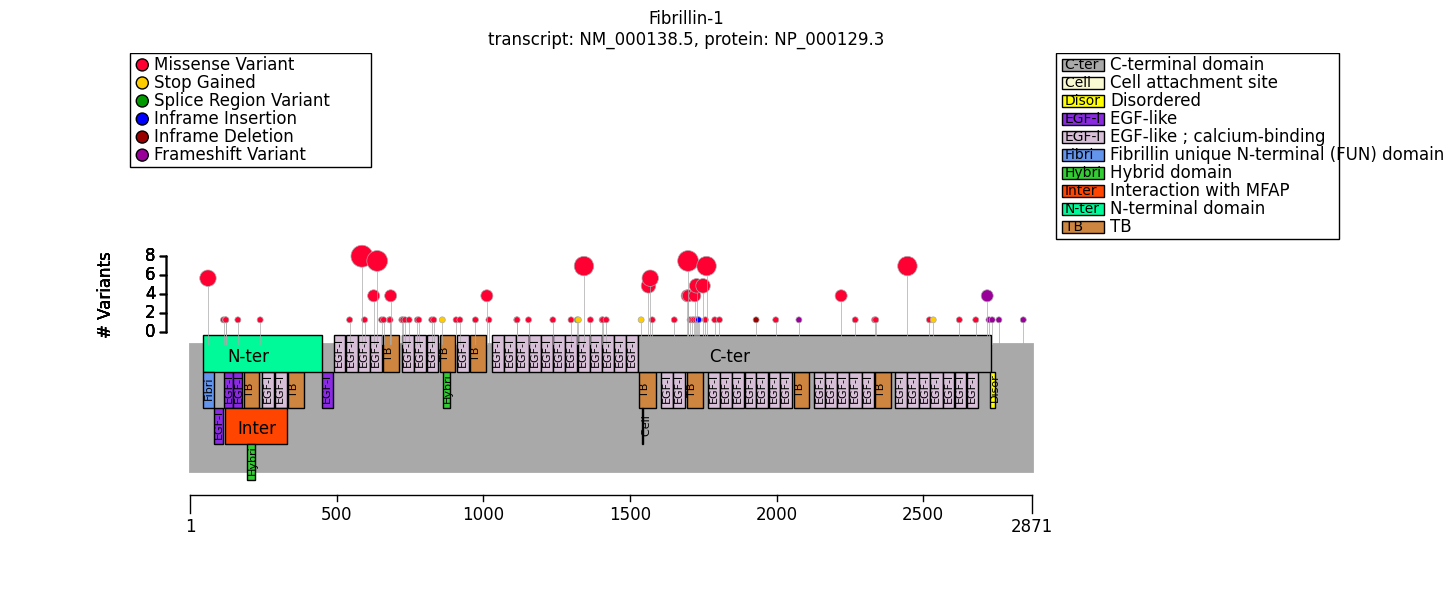

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fbn1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fbn1_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
9,N-terminal domain,Region,46 - 450,p.Arg62Cys; p.Arg122Cys; p.Arg240Cys; p.Cys123Arg; p.Asn164Ser; p.Ser115Cys
4,Fibrillin unique N-terminal (FUN) domain,Region,46 - 81,p.Arg62Cys
0,EGF-like 1,Domain,82 - 112,
2,EGF-like 2,Domain,116 - 146,p.Arg122Cys; p.Cys123Arg
4,Interaction with MFAP4,Region,120 - 329,p.Arg240Cys; p.Cys123Arg; p.Arg122Cys; p.Asn164Ser
1,EGF-like 3,Domain,148 - 178,p.Asn164Ser
0,TB 1,Domain,185 - 236,
0,Hybrid domain 1,Region,196 - 221,
0,EGF-like 4; calcium-binding,Domain,247 - 287,
0,EGF-like 5; calcium-binding,Domain,289 - 329,


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(a_predicate=missense, b_predicate=~missense, a_label="missense", b_label= "other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,45
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,77
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,213


In [10]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Arachnodactyly [HP:0001166]                           34/81     42%  18/22   
Thoracic aortic aneurysm [HP:0012727]                 25/64     39%  12/14   
Ectopia lentis [HP:0001083]                           68/87     78%  11/22   
Aortic root aneurysm [HP:0002616]                    25/115     22%  11/23   
High palate [HP:0000218]                              19/71     27%  10/18   
Short stature [HP:0004322]                            32/78     41%   1/13   
Tall stature [HP:0000098]                             29/90     32%  10/19   
Myopia [HP:0000545]                                   56/78     72%  15/18   
Abnormal appendicular skeleton morphology [HP:0...    66/66    100%  19/19   
Abnormal lens morphology [HP:0000517]                 72/72    100%  11/11   
Abnormality of joint mobility [HP:0011729]            68/68    100%    9/9   

Allele group                                                                   \
                                                   Percent Corrected p values   
Arachnodactyly [HP:0001166]                            82%           0.012670   
Thoracic aortic aneurysm [HP:0012727]                  86%           0.012670   
Ectopia lentis [HP:0001083]                            50%           0.047069   
Aortic root aneurysm [HP:0002616]                      48%           0.047069   
High palate [HP:0000218]                               56%           0.049862   
Short stature [HP:0004322]                              8%           0.049862   
Tall stature [HP:0000098]                              53%           0.182141   
Myopia [HP:0000545]                                    83%           0.530614   
Abnormal appendicular skeleton morphology [HP:0...    100%           1.000000   
Abnormal lens morphology [HP:0000517]                 100%           1.000000   
Abnormality of joint mobility [HP:0011729]            100%           1.000000   

Allele group                                                  
                                                    p values  
Arachnodactyly [HP:0001166]                         0.001392  
Thoracic aortic aneurysm [HP:0012727]               0.002304  
Ectopia lentis [HP:0001083]                         0.014609  
Aortic root aneurysm [HP:0002616]                   0.017116  
High palate [HP:0000218]                            0.026313  
Short stature [HP:0004322]                          0.027197  
Tall stature [HP:0000098]                           0.115908  
Myopia [HP:0000545]                                 0.385901  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Abnormal lens morphology [HP:0000517]               1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000

In [ ]:
# Compare missense variants in cbEGF vs TB domains
from gpsea.analysis.predicate import protein_feature, anyof, allof

tb_domains = list() # TB 1 to TB9
for i in range(1,10):
    label = f"TB {i}"
    is_tb = protein_feature(feature_id=label, protein_metadata=protein_meta)
    tb_domains.append(is_tb)

cbEGF_domains = list() # cbEGF 1 to 47
for i in range(1,48):
    label = f"EGF-like {i}; calcium-binding" 
    is_cbEGF = protein_feature(feature_id=label, protein_metadata=protein_meta)
    cbEGF_domains.append(is_cbEGF)


is_tb = anyof(tb_domains)
is_tb_missense = allof((is_tb, missense))
is_egf = anyof(cbEGF_domains)
is_egf_missense = allof((is_cbEGF, missense))

tb_vs_egf_clf = monoallelic_classifier(
    a_predicate=is_tb, 
    b_predicate=is_egf, 
    a_label="TB domain", b_label="cbEGF")
tb_vs_egf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=tb_vs_egf_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=tb_vs_egf_result)

Allele group                             TB domain          cbEGF          \
                                             Count Percent  Count Percent   
Short stature [HP:0004322]                   23/39     59%   0/24      0%   
Proportionate short stature [HP:0003508]     20/36     56%   0/24      0%   
Severe short stature [HP:0003510]            15/36     42%   0/24      0%   
Tall stature [HP:0000098]                     7/38     18%  21/40     52%   
Ectopia lentis [HP:0001083]                   9/18     50%  48/59     81%   
Myopia [HP:0000545]                          12/17     71%  40/50     80%   
Arachnodactyly [HP:0001166]                   7/17     41%  23/52     44%   
Abnormal lens morphology [HP:0000517]        11/11    100%  50/50    100%   

Allele group                                                               
                                         Corrected p values      p values  
Short stature [HP:0004322]                         0.000004  4.394550e-07  
Proportionate short stature [HP:0003508]           0.000009  2.353473e-06  
Severe short stature [HP:0003510]                  0.000362  1.355862e-04  
Tall stature [HP:0000098]                          0.004344  2.171943e-03  
Ectopia lentis [HP:0001083]                        0.021292  1.330773e-02  
Myopia [HP:0000545]                                0.672207  5.041552e-01  
Arachnodactyly [HP:0001166]                        1.000000  1.000000e+00  
Abnormal lens morphology [HP:0000517]              1.000000  1.000000e+00

# stiff skin
These are three variants (7 observations) from the stiff skin cohort. We are (probably) not seeing the associations because the other
diseases are not annotated to excluded terms.
15_48467994_48467994_C_G	c.4691G>C	p.Cys1564Ser	exon 38	(n=3)
15_48467975_48467975_C_A	c.4710G>T	p.Trp1570Cys	exon 38 (n=2)
15_48467975_48467975_C_G	c.4710G>C	p.Trp1570Cys	38	(n=2)

Note that what the authors call exon 37 is exon 38 because of a non-coding 5' exon.

In [13]:
from gpsea.analysis.predicate import exon

exon_37 = exon(exon=38, tx_id=mane_tx_id)
ex37_clf = monoallelic_classifier(a_predicate=exon_37, b_predicate=~exon_37, a_label="exon 37", b_label="other")
ex37_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ex37_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=ex37_result)

Allele group                               exon 37           other          \
                                             Count Percent   Count Percent   
Stiff skin [HP:0030053]                        8/9     89%    0/50      0%   
Ectopia lentis [HP:0001083]                    1/9     11%  78/100     78%   
Arachnodactyly [HP:0001166]                    0/8      0%   52/95     55%   
Thoracic aortic aneurysm [HP:0012727]          1/9     11%   36/69     52%   
Pectus carinatum [HP:0000768]                  1/1    100%   10/87     11%   
High palate [HP:0000218]                       1/1    100%   28/88     32%   
Abnormal lens morphology [HP:0000517]          3/3    100%   80/80    100%   
Myopia [HP:0000545]                            7/9     78%   64/87     74%   
Abnormality of joint mobility [HP:0011729]     8/8    100%   69/69    100%   

Allele group                                                                 
                                           Corrected p values      p values  
Stiff skin [HP:0030053]                          3.652809e-08  4.058677e-09  
Ectopia lentis [HP:0001083]                      5.031398e-04  1.118088e-04  
Arachnodactyly [HP:0001166]                      8.034459e-03  2.678153e-03  
Thoracic aortic aneurysm [HP:0012727]            6.900550e-02  3.066911e-02  
Pectus carinatum [HP:0000768]                    2.250000e-01  1.250000e-01  
High palate [HP:0000218]                         4.887640e-01  3.258427e-01  
Abnormal lens morphology [HP:0000517]            1.000000e+00  1.000000e+00  
Myopia [HP:0000545]                              1.000000e+00  1.000000e+00  
Abnormality of joint mobility [HP:0011729]       1.000000e+00  1.000000e+00

# C term

In [15]:
exon_59 = exon(exon=60, tx_id=mane_tx_id)
exon_60 = exon(exon=61, tx_id=mane_tx_id)
exon_61 = exon(exon=62, tx_id=mane_tx_id)
exon_62 = exon(exon=63, tx_id=mane_tx_id)
exon_63 = exon(exon=64, tx_id=mane_tx_id)
exon_64 = exon(exon=65, tx_id=mane_tx_id)
exon_65 = exon(exon=66, tx_id=mane_tx_id)

c_term = exon_59 | exon_60 | exon_61 | exon_62 | exon_63 | exon_64 | exon_65
c_term_missense = missense & c_term

c_term_clf = monoallelic_classifier(
    a_predicate=c_term_missense, 
    b_predicate=~c_term_missense, 
    a_label="C term missense", 
    b_label="other")
c_term_missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=c_term_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=c_term_missense_result)

Allele group                                       C term missense          \
                                                             Count Percent   
Joint hypermobility [HP:0001382]                               5/6     83%   
Pectus excavatum [HP:0000767]                                  3/6     50%   
Myopia [HP:0000545]                                            2/6     33%   
Tall stature [HP:0000098]                                      1/1    100%   
Ectopia lentis [HP:0001083]                                    3/5     60%   
Arachnodactyly [HP:0001166]                                    3/6     50%   
Abnormal appendicular skeleton morphology [HP:0...             3/3    100%   
Abnormal lens morphology [HP:0000517]                          3/3    100%   
Abnormality of joint mobility [HP:0011729]                     5/5    100%   

Allele group                                         other          \
                                                     Count Percent   
Joint hypermobility [HP:0001382]                    27/115     23%   
Pectus excavatum [HP:0000767]                        12/98     12%   
Myopia [HP:0000545]                                  69/90     77%   
Tall stature [HP:0000098]                           38/108     35%   
Ectopia lentis [HP:0001083]                         76/104     73%   
Arachnodactyly [HP:0001166]                          49/97     51%   
Abnormal appendicular skeleton morphology [HP:0...   82/82    100%   
Abnormal lens morphology [HP:0000517]                80/80    100%   
Abnormality of joint mobility [HP:0011729]           72/72    100%   

Allele group                                                           \
                                                   Corrected p values   
Joint hypermobility [HP:0001382]                             0.044092   
Pectus excavatum [HP:0000767]                                0.114507   
Myopia [HP:0000545]                                          0.114507   
Tall stature [HP:0000098]                                    0.805046   
Ectopia lentis [HP:0001083]                                  1.000000   
Arachnodactyly [HP:0001166]                                  1.000000   
Abnormal appendicular skeleton morphology [HP:0...           1.000000   
Abnormal lens morphology [HP:0000517]                        1.000000   
Abnormality of joint mobility [HP:0011729]                   1.000000   

Allele group                                                  
                                                    p values  
Joint hypermobility [HP:0001382]                    0.004899  
Pectus excavatum [HP:0000767]                       0.037755  
Myopia [HP:0000545]                                 0.038169  
Tall stature [HP:0000098]                           0.357798  
Ectopia lentis [HP:0001083]                         0.614177  
Arachnodactyly [HP:0001166]                         1.000000  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Abnormal lens morphology [HP:0000517]               1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000

# lipodys

In [16]:
exon_64 = exon(exon=65, tx_id=mane_tx_id)
exon_65 = exon(exon=66, tx_id=mane_tx_id)

frameshift = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
splice = variant_effect(VariantEffect.SPLICE_REGION_VARIANT, tx_id=mane_tx_id)

fs_last_two = (frameshift | splice) & (exon_64 | exon_65)

fs_last_two_clf = monoallelic_classifier(a_predicate=fs_last_two, b_predicate=~fs_last_two, a_label="fs last two", b_label= "other")

fs_last_two_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=fs_last_two_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=fs_last_two_result)

Allele group                                       fs last two          \
                                                         Count Percent   
Hyperextensibility of the finger joints [HP:000...         2/2    100%   
High palate [HP:0000218]                                   3/3    100%   
Joint hypermobility [HP:0001382]                           2/2    100%   
Pectus excavatum [HP:0000767]                              2/4     50%   
Arachnodactyly [HP:0001166]                                4/4    100%   
Scoliosis [HP:0002650]                                     1/1    100%   
Myopia [HP:0000545]                                        4/4    100%   
Abnormal appendicular skeleton morphology [HP:0...         4/4    100%   
Ectopia lentis [HP:0001083]                                3/4     75%   
Abnormal lens morphology [HP:0000517]                      3/3    100%   
Abnormality of joint mobility [HP:0011729]                 3/3    100%   
Thoracic aortic aneurysm [HP:0012727]                      1/2     50%   

Allele group                                         other          \
                                                     Count Percent   
Hyperextensibility of the finger joints [HP:000...    1/90      1%   
High palate [HP:0000218]                             26/86     30%   
Joint hypermobility [HP:0001382]                    30/119     25%   
Pectus excavatum [HP:0000767]                       13/100     13%   
Arachnodactyly [HP:0001166]                          48/99     48%   
Scoliosis [HP:0002650]                               26/93     28%   
Myopia [HP:0000545]                                  67/92     73%   
Abnormal appendicular skeleton morphology [HP:0...   81/81    100%   
Ectopia lentis [HP:0001083]                         76/105     72%   
Abnormal lens morphology [HP:0000517]                80/80    100%   
Abnormality of joint mobility [HP:0011729]           74/74    100%   
Thoracic aortic aneurysm [HP:0012727]                36/76     47%   

Allele group                                                           \
                                                   Corrected p values   
Hyperextensibility of the finger joints [HP:000...           0.008600   
High palate [HP:0000218]                                     0.193054   
Joint hypermobility [HP:0001382]                             0.273278   
Pectus excavatum [HP:0000767]                                0.282611   
Arachnodactyly [HP:0001166]                                  0.282611   
Scoliosis [HP:0002650]                                       0.574468   
Myopia [HP:0000545]                                          0.976920   
Abnormal appendicular skeleton morphology [HP:0...           1.000000   
Ectopia lentis [HP:0001083]                                  1.000000   
Abnormal lens morphology [HP:0000517]                        1.000000   
Abnormality of joint mobility [HP:0011729]                   1.000000   
Thoracic aortic aneurysm [HP:0012727]                        1.000000   

Allele group                                                  
                                                    p values  
Hyperextensibility of the finger joints [HP:000...  0.000717  
High palate [HP:0000218]                            0.032176  
Joint hypermobility [HP:0001382]                    0.068320  
Pectus excavatum [HP:0000767]                       0.098527  
Arachnodactyly [HP:0001166]                         0.117754  
Scoliosis [HP:0002650]                              0.287234  
Myopia [HP:0000545]                                 0.569870  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Ectopia lentis [HP:0001083]                         1.000000  
Abnormal lens morphology [HP:0000517]               1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000  
Thoracic aortic aneurysm [HP:0012727]               1.000000

In [24]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

result_list = [missense_result, tb_vs_egf_result ,ex37_result, fs_last_two_result]
f_results = [GPAnalysisResultSummary.from_multi(r) for r in result_list]

FBN1_caption = ""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=FBN1_caption)

In [25]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,missense,other,p-val,adj. p-val
Arachnodactyly [HP:0001166],34/81 (42%),18/22 (82%),0.001,0.013
Ectopia lentis [HP:0001083],68/87 (78%),11/22 (50%),0.015,0.047
High palate [HP:0000218],19/71 (27%),10/18 (56%),0.026,0.050
Aortic root aneurysm [HP:0002616],25/115 (22%),11/23 (48%),0.017,0.047
Thoracic aortic aneurysm [HP:0012727],25/64 (39%),12/14 (86%),0.002,0.013
Short stature [HP:0004322],32/78 (41%),1/13 (8%),0.027,0.050
HPO Term,TB domain,cbEGF,p-val,adj. p-val
Ectopia lentis [HP:0001083],9/18 (50%),48/59 (81%),0.013,0.021
Tall stature [HP:0000098],7/38 (18%),21/40 (52%),0.002,0.004
Severe short stature [HP:0003510],15/36 (42%),0/24 (0%),1.36e-04,3.62e-04


In [26]:
summarizer.process_latex(report=report, protein_fig=fbn1_fig)

Figure saved to ../../supplement/img/FBN1_protein_diagram-draft.pdf
Output to ../../supplement/tex/FBN1_summary_draft.tex
